<a href="https://colab.research.google.com/github/mkorlyakova/test-face-recognition/blob/main/hypothesis_2_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Импорт рабочих библиотек**

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2 as cv
import tarfile

from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import scipy.stats as st

import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence

Подключение к диску с данными

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


## *Гипотеза* 2 : 
  **metric lening**

###  Реализация:
 - проводим массивный поиск гиперпараметров:    
      - по функциям потерь
      - по размеру сети
      - по Эмбедингу [32-128]
 - предобработки : ?
 - тренировка сети: выделить валидационный кусок и тренировочный 
 - анализ результат (метрики): accuracy, EER, FAR,FRR





Вопрос: ВАЖЕН ЛИ СПОСОБ СЖАТИЯ из 112 в 32?


In [ ]:
# Генератор данных для обучения
class CustomDataGenFace(Sequence):
  
  '''
  читаем и распаковываем файлы порциями batch_size размера

  Важно, что не нужно менять подгорнять размеры папок, это сделано 
  за счет разнообразия случайно включаемых папок 
  в каждом пакете есть примеры похожие и нет (в норме 2-3 типа объектов), они собираются в пары уже в сети при обучении 
  ключ схожести label название папки с примерами и его генератор вычисляет налету
  Изображение подвергаю масштабированию в 32x32x3 и перевожу в Lab (предполагается , что цветовой тон важен)
  '''
  
  def __init__(self, 
               batch_size,
               input_size=(32, 32, 3),
               zipfile = '/gdrive/MyDrive/Face recognition/casia_faces.tar.gz',
               lab = 1,
               scale = [32,32],
               shuffle=True,
               ind1 = 1,
               ind2 = 10000):
    """
    batch_size, - размер пакета
    input_size=(32, 32, 3), - размер картинки на входе генератора
    zipfile = '/gdrive/MyDrive/Face recognition/casia_faces.tar.gz',
    lab = 1, - переводить в  Lab = 1, нет = 0
    scale = [32,32], - финальный размер
    shuffle=True, - смешивать
    ind1 = 1,ind2 = 10000 - индексы по списку распаковки для немедленного 
    вытаскивания на диск (от  ind1 до ind2)
    
    """

    super().__init__()
    self.__batch_size = batch_size # 1
    self.input_size = input_size # 
    self.shuffle = shuffle
    self.scale = scale
    self.lab = lab # Lab
    self.zipfile = zipfile
    self.ind1 = ind1
    self.ind2 = ind2

    # открыть данные из архива на локальный диск
    if self.zipfile.endswith("tar.gz"):
      self.tar = tarfile.open(self.zipfile, "r:gz")
    elif self.zipfile.endswith("tar"):
      self.tar = tarfile.open(self.zipfile, "r:")
    self.ll = self.tar.getmembers( )
    self.tar.extractall( '.', self.ll[ind1:ind2] )
    self.tar.close()
  
  #batch_size - свойство размер пакета
  @property
  def batch_size(self):
        self.__batch_size
  @batch_size.setter      
  def batch_size(self, batch_size):
        self.__batch_size = batch_size
        
  @batch_size.getter
  def batch_size(self):
        return self.__batch_size  


  def label_extract(self,index):
    # парсинг метки из имени файлов
    try:
      #print(index)
      # полное имя имеет префикс person_ дальше идет номер класса
      s = self.ll[index].name.split('/')
      #print(self.ll[index])
      # если не каталог, то извлекаем номер и установим метку класса
      if len(s)>2:
      #if s[-2].find('person_')>=0:
        k = s[-2].find('person_')
        #print(k)
        if k>=0:
          label = s[-2][k+7:]
          #print(label)
          return int(label)
        else:
          return -1  
      else:
        return -1
    except FileNotFoundError:
      return -1      
  
  def image_extract(self,index):
    # чтение картинки из файла для файла с номером index
    try:
      s = self.ll[index].name
      # открываем файл, если успешно, делаем изменение размеров, Lab и вернем 
      img = cv.imread(s )
      if type(img) == type(cv.imread('')) :
        return np.zeros((1,32,32,1)), 0  
      else:
        img = cv.resize(img,(self.scale[1],self.scale[0]))
          
      if self.lab:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
      img = img.reshape(-1,self.scale[1],self.scale[0],1)
      return img, np.mean(img)
    except FileNotFoundError:
      return np.zeros((1,32,32,1)), 0
  
  #rotate image
  def rotation(self, image, angle):
    s = image.shape
    center=tuple(np.array([s[0],s[1]])/2)
    rot_mat = cv.getRotationMatrix2D(center,angle,1.0)
    new_image = cv.warpAffine(image, rot_mat, (s[1],s[0]))
    return 
    

  def getitemIL(self, index):
    #обработка одного примера
    image = []
    label = []
    try:
      i = 0
      
      while (len(label)<1)&(i<10):
        
        k = self.label_extract(index + i)
        if k>= 0:
          image_, m = self.image_extract(index+i)
          if m>0:
            label_ = k
            #print(image_.shape, label_)
            image = image_
            label = label_
        i += 1
          
      return np.array(image),np.array(label)
    except FileNotFoundError:
      return np.zeros((1,32,32,1)),-1* np.ones((1, ))
  
  
  def __len__(self):
    
    return len(self.ll) // self.batch_size  
    
  def __getitem__(self, index):
    #получить папакет примеров
    image = []
    label = []
    try:
      i = 0
      ind = np.random.randint(0,self.__batch_size, (self.__batch_size*2))
      # Если индекс больше или меньше, текущего прочитанного диапазона, то дочитать из файла
      if (index<self.ind1)or((index+self.__batch_size)>self.ind2):
            print(index)
            if self.zipfile.endswith("tar.gz"):
              self.tar = tarfile.open(self.zipfile, "r:gz")
            elif self.zipfile.endswith("tar"):
              self.tar = tarfile.open(self.zipfile, "r:")
            self.ll = self.tar.getmembers( )
            self.tar.extractall( '.', self.ll[index:index+self.__batch_size] )
            #for k in self.ll[index:index+self.__batch_size]:
            #  self.tar.extractall( k )
            self.tar.close()
      # накапливаем примеры в пакет
      while (len(label)<self.__batch_size)&(i<self.__batch_size*2):
        # получить метку
        k = self.label_extract(index+ind[i])
        if k>= 0:
          # получить картинку
          image_, m = self.image_extract(index+ind[i])
          if m>0:
            label_ = k
            #print(image_.shape, label_)
            image.append(image_[0,:,:,:])
            label.append(label_)
        i += 1
          
      return np.array(image),np.array(label)
    except FileNotFoundError:
      return np.zeros((1,32,32,1)),-1* np.ones((1, ))
  def __len__(self):
    # возможное число пакетов
    return len(self.ll) // self.batch_size

Схема сети для эмбединга: 

 - layer[0] сверточных блоков (С-С-MP)
 - layer[1] полносвязных блоков (FC-Drop)

In [ ]:
# Custom model Class
# делаем обучение по SiamNet

class CustomModel(tf.keras.Model):
    def calc_metrics(self, targets_scores, imposter_scores):
      """
          
      targets_scores - значения выхода модели через метрику для пар, 
      imposter_scores - значения выхода модели через метрику для не пар,
    
      
      """
      # диапазоны

      min_score = np.minimum(np.min(targets_scores), np.min(imposter_scores))
      max_score = np.maximum(np.max(targets_scores), np.max(imposter_scores))
      print(min_score,max_score)
      n_tars = len(targets_scores)
      n_imps = len(imposter_scores)
      # число точек
      N = 100
      # создаем метрики
      fars = np.zeros((N,))
      frrs = np.zeros((N,))
      dists = np.zeros((N,))

      mink = float('inf')
      eer = 0
      min_i = 0
      # поиск оптимальной точки
      for i, dist in enumerate(np.linspace(min_score, max_score, N)):
        far = len(np.where(imposter_scores > dist)[0]) / n_imps
        frr = len(np.where(targets_scores < dist)[0]) / n_tars
        # добавили оценки по этому порогу для dist
        fars[i] = far
        frrs[i] = frr
        dists[i] = dist

        k = np.abs(far - frr)

        if k < mink:
          mink = k
          min_i = i
          eer = (far + frr) / 2
      
      # accuracy

      if n_tars>n_imps:
        nn = n_imps
      else:
        nn = n_tars
      TN = np.sum(imposter_scores[:nn] > dists[min_i]) 
      TP = np.sum(targets_scores[:nn] < dists[min_i])
      acc = (TP+TN)/(nn*2)


      return eer, fars, frrs, dists, min_i, acc
    
    # Функция потерь Contrastiv 
    def contastive_loss(self,embs, labels):
      #print(embs.shape,labels.shape)
      bs = embs.shape[0]
      embs1 = embs[:bs//2, :]
      embs2 = embs[bs//2:, :]
  
      labels1 = labels[:bs//2]
      labels2 = labels[bs//2:]
      #print(labels1,labels2)
      d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
      d =  tf.sqrt(d2)
      z = tf.cast(labels1 == labels2, tf.float32)
      #print(z.dtype,d.dtype, d2.dtype)
      MARGIN = 100.0
      return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0.0, MARGIN - d)**2)

    # https://www.pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
    # Функция потерь - родной из tf как-то неправильно обработал мой тензор - делаю свою
    def loss_cos(self,embs, labels):
      # print(embs,labels)
      bs = embs.shape[0]
      embs1 = embs[:bs//2, :]
      embs2 = embs[bs//2:, :]
      #print(embs1,embs2)
      labels1 = labels[:bs//2]
      labels2 = labels[bs//2:]
      #print(labels1,labels2)
 
      d2 =tf.reduce_sum(embs1 * embs2, axis =-1 )/tf.reduce_sum( embs1 ** 2, axis = -1) / tf.reduse_sum( embs2 ** 2, axis = -1)
      #print(d2.shape)
      d =  tf.abs(d2 - 1)
      z = tf.cast(labels1 == labels2, tf.float64)
      print(z.dtype(),d.dtype)
      return tf.reduce_mean(z * d + (1-z)*(d2))   
    #  Для получения оценок L2  
    def my_embed_metric(self, X,L):
      
      net_dist = tf.ones( (X.shape[0],X.shape[0]),dtype=tf.float32) # нормированное расстояние - инициализация 1(пока)
      label_dist = tf.ones((X.shape[0],X.shape[0]),dtype=tf.int8) # нормированное расстояние - инициализация 1(пока)
      for i in range(X.shape[0]-1):
        for j in range(i+1,X.shape[0]):
          net_dist[i,j] = tf.reduce_sum( tf.square(tf.cast(X.numpy()[i:i+1,:],dtype = tf.float32)- tf,cast(X.numpy()[j:j+1,:],dtype = tf.float32)), axis=-1)( )
          net_dist[j,i] =  net_dist[i,j]
          label_dist[i,j] = tf.cast(L[i] == L[j],dtype=tf.int8)
          label_dist[j,i] =  label_dist[i,j]
      return net_dist, label_dist      
    
    #Шаг обучения нейронки
    def train_step(self, data):
        # получить данные из data
        # oделаем прямой проход
        image, label = data
        #print(image.shape)      
        with tf.GradientTape() as tape:
            y_pred = self(image, training=True)  # Forward pass
            #print(y_pred.shape)
            # строим потери
            loss = self.contastive_loss(y_pred, label)

        # строим Градиент
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # адаптация
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # метрика
        '''
        
        y_pred = self(image, training=True)
        print(y_pred.shape,y_pred[:2,:5])
        n_d,n_l = my_embed_metric( y_pred.numpy(),label.numpy())
        ind1 = tf.where(n_l == 1)
        ind0 = tf.where( n_l == 0)
        print(ind1.shape)
        targets_scores = n_d[ind1,:]
        imposter_scores = n_d[ind0,:]
        eer, fars, frrs, dists, min_i, acc = self.calc_metrics(targets_scores, imposter_scores)
        '''
 
        #self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {'dist':loss}

Создаем Нейронную сеть в схеме SiamesNet#
 - сверточные слои (без трансферной сети , т.к. маленькая задача)
 - полносвязные слои 

In [13]:
def net_creat_c(EMB_SIZE = 64, im_size = (32,32,1),X_size = 8, layer = [5,3], numb_neuro = 1, loss = 'mse', opt = 'Adam', metrics = ['accuracy']):
  # поток I
  inp_x_im = tf.keras.layers.Input(shape=(im_size[0], im_size[1], im_size[2]))
  
  x1 = tf.keras.layers.Conv2D(32*numb_neuro, (3, 3), padding='same', activation='relu')(inp_x_im)
  
  for k in range(layer[0]):
    x2 = x1
    x1 = tf.keras.layers.Conv2D(64*numb_neuro, (3, 3), padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.Conv2D(64*numb_neuro, (3, 3), padding='same', activation='relu')(x1)
    x1  = tf.keras.layers.concatenate([x1,x2])
    x1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x1)
    
  x1 = tf.keras.layers.Flatten()(x1)
  # поток Х 
  x = tf.keras.layers.Dense(256, activation='relu')(x1)
  x = tf.keras.layers.Dropout(0.5)(x)
  for k in range(layer[1]):
    x = tf.keras.layers.Dense(EMB_SIZE*numb_neuro, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
  # Выход эмбединга  
  x = tf.keras.layers.Dense(EMB_SIZE, activation=None)(x)


  model = CustomModel( inputs =inp_x_im, outputs = x)
  model.compile(optimizer=opt,loss=loss,metrics=metrics)
  return model

### **Метрики:**

In [ ]:
# вычисление метрики для вложеня (Euqlid)
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5
# cos
def diffc(e1, e2):
    return 1 - np.sum((e1 * e2))/np.sum( (e1**2)) ** 0.5/np.sum( (e2**2)) ** 0.5    

# метрики по эмбедингу (вложению)
def my_embed_metric(X,L):
  net_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  label_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  for i in range(X.shape[0]-1):
    for j in range(i+1,X.shape[0]):
      net_dist[i,j] = diff( X[i,:],X[j,:])
      net_dist[j,i] =  net_dist[i,j]
      label_dist[i,j] = int(L[i] == L[j])
      label_dist[j,i] =  label_dist[i,j]

      

      
  return net_dist, label_dist# 

def test_data(gen_d, ind=13200):
  I = []
  L = []
  
  
  # получаем размер пакета генератора
  batch_size = gen_d.batch_size*2
  
 
  if 1:
    # строим 2 пакета
    I1,L_1 = gen_d[ind]
    I2,L_2 = gen_d[ind+ np.random.randint(5000)]
    #склеиваем их
    I = np.vstack((I1,I2))
    L = np.hstack( (L_1,L_2))

    #смешать данные

    ind1 = np.arange(len(L_1)).tolist()
    
    ind2 = (np.arange(len(L_2)) + (batch_size // 2)).tolist()

    ind  = ind1[::2]+ind2[::2]+ind1[1::2]+ind2[1::2]

    
    I = I[ind,:,:,:]
    L = L[ind]
    print(I.shape,L.shape)
    return I,L
    


def image_clast_net(I,L,  model=None,    verbose=1):
  '''
  полный цикл  анализа
  вход:
  image_name - имя картинки,
  
  gen_d - генератор примеров 
  model - модель сети для анализа 
  
  гиперпараметры алгоритма:

,  
  
  verbose = 1 - визуализировать результат (0 - не визуализировать)


  
  ''' 

  # строим метрики
  if 1:
      batch_size = len(L)  
      # получили эмбединг от модели
      X_emb = model.predict(I)
      # Строим оценки всех пар 
      #(n_emb - расстояние в паре,l_dist - тип пары (1 одинаковые, 0 - разные) )
      n_emb,l_dist = my_embed_metric(X_emb,L)

      if verbose:
        plt.figure(figsize = (16,5))
        plt.subplot(1,3,1)
        plt.imshow(n_emb)
        plt.title('Эмбединг')
        plt.subplot(1,3,2)
        plt.imshow(n_emb * l_dist)
        plt.title('Эмбединг 1')
        plt.subplot(1,3,3)
        plt.imshow(n_emb * (-l_dist+1))
        plt.title('Эмбединг 0')  
        plt.show()
      # анализ 
      # делим по меткам пар на похожие и нет пары 
      Dist1 = []
      Dist0 = []
      for i in range(batch_size):
        for j in range(i+1,batch_size-1):
          if l_dist[i,j] :
            Dist1.append(n_emb[i,j])
          else:
            Dist0.append(n_emb[i,j])  
      if verbose:
        plt.figure(figsize = (16,5))
        plt.subplot(1,2,1)
        plt.hist(Dist0,alpha = 0.5,bins = 100, label = 'labeli!=labelj : 0')
        plt.hist(Dist1,alpha = 0.5,bins = 100, label = 'labeli==labelj : 1')
        plt.legend()
      
        plt.grid(True)
        plt.title('распределение рaсстояний по типам пар')
        plt.subplot(1,2,2)
        sns.kdeplot(Dist0,)
        sns.kdeplot(Dist1)
        plt.grid(True)
        plt.legend()
        plt.title('распределение рaсстояний по типам пар')
        plt.show()
      # среднее по выборке расстояние
      m0 = np.mean(Dist0)
      m1 = np.mean(Dist1)
      print('средняя дистанция по 0:',m0)
      print('средняя дистанция по 1:',m1)
      # std по выборкам
      d0 = np.std(Dist0)
      d1 = np.std(Dist1)
      # проверим сходство непараметрическими тестами
      L1 = len(Dist1)
      L0 = len(Dist0)
      if L1>L0:
        L_d01 = L0
      else:
        L_d01 = L1  
      print('std по 0:',d0)
      print('std по 1:',d1)
      conf_int0 = st.t.interval(0.99, len(Dist0)-1, loc=np.mean(Dist0), scale=st.sem(Dist0))
      conf_int1 = st.t.interval(0.99, len(Dist1)-1, loc=np.mean(Dist1), scale=st.sem(Dist1))
      print('доверит.интервал 0',conf_int0)
      print('доверит.интервал 1',conf_int1)
      print('интервал 3 sigms 0',[m0-d0*3,m0+d0*3])
      print('интервал 3 sigma 1',[m1-d1*3,m1+d1*3])
      if verbose:
        plt.plot([0,0,0],[conf_int0[0],m0,conf_int0[1]],'-og', label='0')
        plt.plot([1,1,1],[conf_int1[0],m1,conf_int1[1]], '-ok',label='1')
        plt.plot([0,0,0],[m0-d0,m0,m0+d0],'--xb', label='+-sigma 0')
        plt.plot([1,1,1],[m1-d1,m1,m1+d1], '--xr',label='+-sigma 1')
        plt.legend()
        plt.title('доверит.интервал по типам пар и +-sig')
        plt.show()
      wc = wilcoxon(Dist1[:L_d01],Dist0[:L_d01])[1]
      mu = mannwhitneyu(Dist1,Dist0)[1]
      print('тест Мана-Уитни p_value:', mu)
      print('тест Вилкокса p_value:', wc)
      stat_rez = [m0,m1,d0,d1,conf_int0[0],conf_int0[1],conf_int1[0],conf_int1[1],mu,wc,m0-d0*3,m0+d0*3,m1-d1*3,m1+d1*3]

      
  
  else:
    print('не найден файл')
  return I, L, n_emb, l_dist, stat_rez
# Предсказание
# L2
def L2_metric(X1,X2):
  return np.sum((X1-X2) ** 2) ** 0.5
# cos
def cos_metric(X1,X2):
  return np.dot(X1.T/(np.sum(X1*X1))**0.5,X2/(np.sum(X2*X2))**0.5) 

# предикт по одному примеру
def predict(I1,I2,model):
  I = np.array([I1[:,:,:],I2[:,:,:]])
  X_emb = model.predict(I)
  n_emb = L2_metric(X_emb[0,:],X_emb[1,:])
  return n_emb

# предикт для пакета
def pred_batch(ind, model,gen_d):
  I,L = gen_d[ind]
  n_emb = []
  for i in range(len(L)//2):
    p = predict(I[i,:,:,:],I[len(L)//2+i,:,:,:],model)
    #print(p,I[i,:,:,:].mean(),I[len(L)//2+i,:,:,:].mean())
    n_emb.append([p, int(L[i]==L[len(L)//2+i])])  
  return n_emb


# https://habr.com/ru/post/317798/

def calc_metrics(targets_scores, imposter_scores):
    """
    targets_scores - значения выхода модели через метрику для пар, 
    imposter_scores - значения выхода модели через метрику для не пар,
    """
    # диапазоны
    min_score = np.minimum(np.min(targets_scores), np.min(imposter_scores))
    max_score = np.maximum(np.max(targets_scores), np.max(imposter_scores))
    print(min_score,max_score)
    n_tars = len(targets_scores)
    n_imps = len(imposter_scores)

    N = 100

    fars = np.zeros((N,))
    frrs = np.zeros((N,))
    dists = np.zeros((N,))

    mink = float('inf')
    eer = 0
    min_i = 0
    # поиск оптимальной точки
    for i, dist in enumerate(np.linspace(min_score, max_score, N)):
        far = len(np.where(imposter_scores > dist)[0]) / n_imps
        frr = len(np.where(targets_scores < dist)[0]) / n_tars
        # добавили оценки по этому порогу для dist
        fars[i] = far
        frrs[i] = frr
        dists[i] = dist

        k = np.abs(far - frr)

        if k < mink:
            mink = k
            min_i = i
            eer = (far + frr) / 2
    # accuracy

    if n_tars>n_imps:
      nn = n_imps
    else:
      nn = n_tars
    TN = np.sum(imposter_scores[:nn] > dists[min_i]) 
    TP = np.sum(targets_scores[:nn] < dists[min_i])
    acc = (TP+TN)/(nn*2)


    return eer, fars, frrs, dists, min_i, acc

## **Обучение модели:**

- выбраные гиперпараметры: layer = [1,2], EMB_SIZE = 64,пакет на вход модели  100 объектов (выдача генератора)
- обучаем на части доступных данных : первые 400000 объектов, валидация после 400000
- сдвигаю область текущих примеров для обучения в диапазоне от 1 до 400000 (экономим размер места на диске)
- Записываю веса нейронки после  каждой эпохи на диск
- Меняю состав тренировочной и валидационной выборки в пределах отделенных для этого данных
-фиксирую: статистики, EER,FAR,FRR, Accuracy(на выравниваемой выборке по label)

Запуск генератора: 
  - читаем каталог примеров на диск
  - задаем размер пакета (200)

In [ ]:
gen_d = CustomDataGenFace(200)

In [15]:


LEARNING_RATE = 0.001 # скорость обучения

# оптимизатор
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# зазор
MARGIN = 100.0
modelc = net_creat_c(EMB_SIZE = 64, im_size = (32,32,1),X_size = 8,  layer = [1,2], numb_neuro=1)
#modelc.load_weights('/gdrive/MyDrive/Face recognition/siam_net_rez_.h5')
# хранение логов
hist = []
acc_list = []
eer_list = []
gen_d.batch_size = 200 # размер пакета генератора

Цикл обучения сети
  - сформировать пакет для обучения в области данных до 300000 индекса 
  - запустить сеть на обучение



  данные для обучения :

Данные для теста

In [ ]:
It,Lt = test_data(gen_d, ind=300000)

300000
302300
(400, 32, 32, 1) (400,)


223764
288819
177632
254262
192744
56101
158412
20620
146156
57697
0 : (2000, 32, 32, 1)
Epoch 1/20
50/50 [==============================] - 1s 23ms/step - dist: 582.5361 - val_loss: 41865156.0000 - val_accuracy: 0.0000e+00
Epoch 2/20
50/50 [==============================] - 1s 22ms/step - dist: 832.6000 - val_loss: 41865908.0000 - val_accuracy: 0.0000e+00
Epoch 3/20
50/50 [==============================] - 1s 20ms/step - dist: 602.6787 - val_loss: 41865704.0000 - val_accuracy: 0.0000e+00
Epoch 4/20
50/50 [==============================] - 1s 22ms/step - dist: 618.9032 - val_loss: 41864236.0000 - val_accuracy: 0.0000e+00
Epoch 5/20
50/50 [==============================] - 1s 22ms/step - dist: 590.7251 - val_loss: 41864472.0000 - val_accuracy: 0.0000e+00
Epoch 6/20
50/50 [==============================] - 1s 21ms/step - dist: 724.3577 - val_loss: 41864180.0000 - val_accuracy: 0.0000e+00
Epoch 7/20
50/50 [==============================] - 1s 22ms/step - dist: 710.9822 - val_loss: 4186440

<Figure size 1152x360 with 0 Axes>

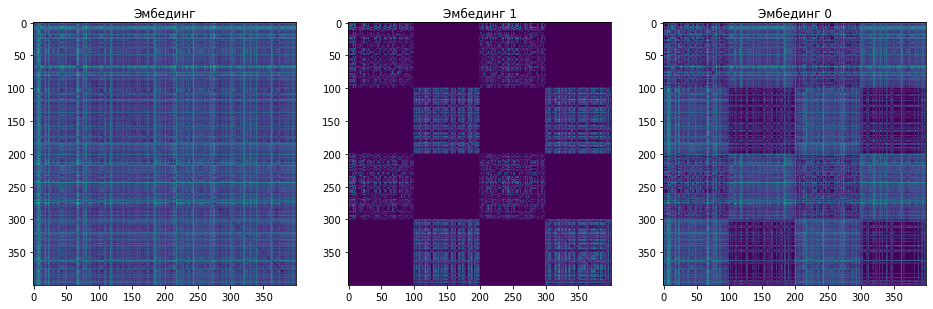

No handles with labels found to put in legend.


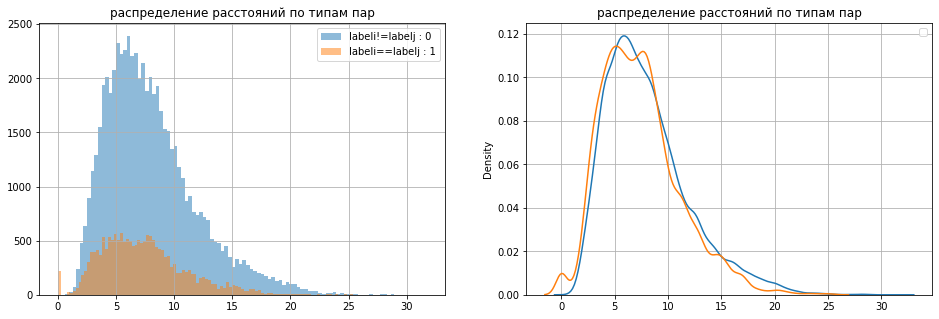

средняя дистанция по 0: 8.01541226815137
средняя дистанция по 1: 7.363602863764297
std по 0: 3.9198760630280005
std по 1: 3.6739650219473905
доверит.интервал 0 (7.974695584395909, 8.056128951906832)
доверит.интервал 1 (7.29286372629032, 7.4343420012382735)
интервал 3 sigms 0 [-3.7442159209326302, 19.77504045723537]
интервал 3 sigma 1 [-3.6582922020778748, 18.38549792960647]


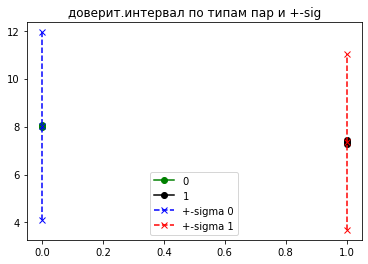

тест Мана-Уитни p_value: 8.244656055258728e-71
тест Вилкокса p_value: 8.521768322448167e-103
0.0 31.734977953097648


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


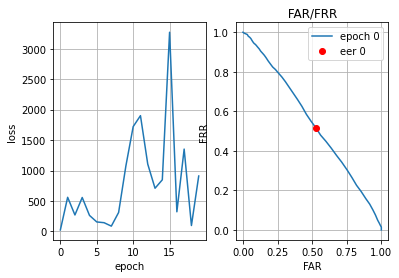

168926
145679
175230
259468
195643
15509
266066
197078
293318
1 : (2000, 32, 32, 1)
Epoch 1/20
50/50 [==============================] - 1s 24ms/step - dist: 868.3072 - val_loss: 41154552.0000 - val_accuracy: 0.0000e+00
Epoch 2/20
50/50 [==============================] - 1s 21ms/step - dist: 965.4842 - val_loss: 41156108.0000 - val_accuracy: 0.0000e+00
Epoch 3/20
50/50 [==============================] - 1s 23ms/step - dist: 799.8591 - val_loss: 41155456.0000 - val_accuracy: 0.0000e+00
Epoch 4/20
50/50 [==============================] - 1s 22ms/step - dist: 825.0686 - val_loss: 41157320.0000 - val_accuracy: 0.0000e+00
Epoch 5/20
50/50 [==============================] - 1s 23ms/step - dist: 891.9359 - val_loss: 41156744.0000 - val_accuracy: 0.0000e+00
Epoch 6/20
50/50 [==============================] - 1s 22ms/step - dist: 848.8293 - val_loss: 41156560.0000 - val_accuracy: 0.0000e+00
Epoch 7/20
50/50 [==============================] - 1s 22ms/step - dist: 565.5918 - val_loss: 41157444.000

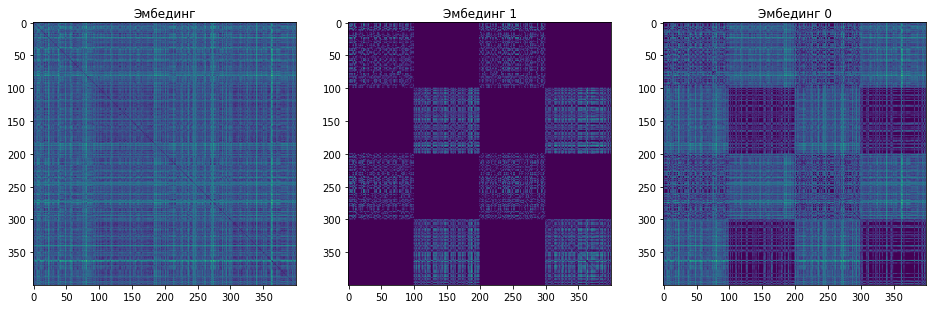

No handles with labels found to put in legend.


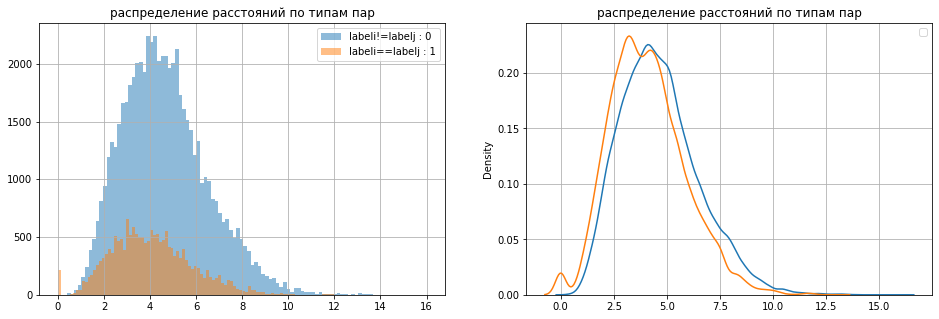

средняя дистанция по 0: 4.647214262205491
средняя дистанция по 1: 4.075416999245238
std по 0: 1.843636712656014
std по 1: 1.757572555861267
доверит.интервал 0 (4.628063969751809, 4.666364554659173)
доверит.интервал 1 (4.041576403075474, 4.109257595415002)
интервал 3 sigms 0 [-0.8836958757625508, 10.178124400173534]
интервал 3 sigma 1 [-1.1973006683385625, 9.34813466682904]


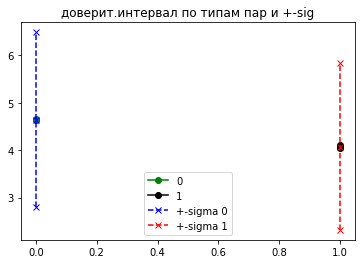

тест Мана-Уитни p_value: 1.2612945042111928e-274
тест Вилкокса p_value: 1.3090155421122462e-253
0.0 16.013106699876843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


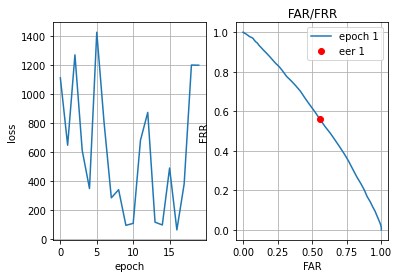

In [21]:
NUM_EPOCHS = 2
acc = -np.inf
plt.figure(figsize = (16,5))
#loss_func = contastive_loss
for ch in range(NUM_EPOCHS):
  # данные для обучения
  I,L = gen_d[np.random.randint(0,300000)]
  for i in range(1,10):
      ind_i = np.random.randint(0,300000)
      I_,L_ = gen_d[ind_i]
      I = np.vstack((I,I_))
      L = np.hstack((L,L_))
  print(ch, ':',I.shape)

  hist = modelc.fit(I, L,epochs=20, batch_size=32, verbose = 1,validation_split=0.2)
    

  #model, hist = train_step(model, I,L, hist,loss_func)

  #model.save_weights('/gdrive/MyDrive/Face recognition/siam_net_rez_.h5')

  ind_test = 300000+np.random.randint(0,10000)
  It, Lt, n_emb, l_dist,stats_rez = image_clast_net(It,Lt,  model=modelc,    verbose=1)
  
  plt.subplot(1,2,1)
  plt.plot(hist.history['dist'] )
  r_embed = []
  for i in range(n_emb.shape[0]):
    for j in range(i+1,n_emb.shape[0]-1):
      r_embed.append( [n_emb[i,j],l_dist[i,j]]) 
  #r_embed  =pred_batch(ind_test, model,gen_d)
  r_embed = np.array(r_embed)
  ind1 = np.where(r_embed[:,1] == 1)[0]
  ind0 = np.where(r_embed[:,1] == 0)[0]
   
  eer_,far,frr,dist_, pdist, acc_ = calc_metrics(r_embed[ind1,0],r_embed[ind0,0])
  # Перезаписывать, если произошло улучшение модели 
  if acc_> acc:
    modelc.save_weights('/gdrive/MyDrive/Face recognition/siam_net_rez_.h5')
    acc = acc_
  plt.subplot(1,2,2)
  plt.plot(far,frr, label ='epoch '+str(ch) )
  plt.plot(far[pdist],frr[pdist],'ro', label ='eer '+str(ch) )
  eer_list.append([eer_,acc_])
  acc_list.append(acc)
  plt.subplot(1,2,1)
  plt.grid(True)
  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.subplot(1,2,2)
  plt.grid(True)
  plt.title(' FAR/FRR ')
  plt.xlabel('FAR')
  plt.ylabel('FRR')
  plt.legend()
  plt.show()  

In [22]:
acc

0.5711373030946263

Аккуратность текущего результата 57% (тест сбалансиролван)